## Code Modules

In [1]:
!pip install --upgrade neural_structured_learning --user

     |████████████████████████████████| 104 kB 6.3 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd,numpy as np,pylab as pl
import os,h5py,cv2,tensorflow as tf
import tensorflow_hub as th
import neural_structured_learning as nsl
from sklearn.model_selection import train_test_split
fpath='../input/image-classification-for-biospecies-2/'
fw='weights.best.hdf5'

## Data

['test_images', 'test_labels', 'train_images', 'train_labels']


,train,valid,test
image shape,"(3303, 128, 128, 3)","(183, 128, 128, 3)","(184, 128, 128, 3)"
image type,float32,float32,float32
label shape,"(3303, 1)","(183, 1)","(184, 1)"
label type,int32,int32,int32
shape of encoded label,"(3303, 120)","(183, 120)","(184, 120)"
type of encoded label,int32,int32,int32


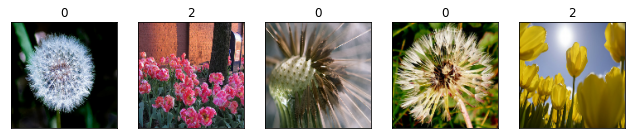

In [3]:
f=h5py.File(fpath+'TfFlowerImages.h5','r')
keys=list(f.keys()); print(keys)
x_test=np.array(f[keys[0]]); y_test=np.array(f[keys[1]])
x_train=np.array(f[keys[2]]); y_train=np.array(f[keys[3]])
fig=pl.figure(figsize=(11,4))
n=np.random.randint(1,50); n_classes=120
for i in range(n,n+5):
    ax=fig.add_subplot(1,5,i-n+1,\
    xticks=[],yticks=[],title=y_test[i][0])
    ax.imshow((x_test[i]))
cy_train=np.array(tf.keras.utils\
.to_categorical(y_train,n_classes),dtype='int32')
cy_test=np.array(tf.keras.utils\
.to_categorical(y_test,n_classes),dtype='int32')
n=int(len(x_test)/2)
x_valid,y_valid,cy_valid=x_test[:n],y_test[:n],cy_test[:n]
x_test,y_test,cy_test=x_test[n:],y_test[n:],cy_test[n:]
df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                 [x_train.dtype,x_valid.dtype,x_test.dtype],
                 [y_train.shape,y_valid.shape,y_test.shape],
                 [y_train.dtype,y_valid.dtype,y_test.dtype],
                 [cy_train.shape,cy_valid.shape,cy_test.shape],
                 [cy_train.dtype,cy_valid.dtype,cy_test.dtype]],
                 columns=['train','valid','test'],
                 index=['image shape','image type',
                        'label shape','label type',
                        'shape of encoded label',
                        'type of encoded label'])
display(df)

## NN Examples
CNN Based Models with Adversarial Regularization

In [4]:
batch_size=64; img_size=128; n_class=5; epochs=7
base_model=tf.keras.Sequential([
    tf.keras.Input((img_size,img_size,3),name='input'),
    tf.keras.layers.Conv2D(32,(5,5),padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Conv2D(196,(5,5)),
    tf.keras.layers.Activation('relu'),    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.GlobalMaxPooling2D(),    
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(10,activation='softmax')
])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
adv_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [5]:
train=tf.data.Dataset.from_tensor_slices(
    {'input':x_train,'label':y_train}).batch(batch_size)
valid=tf.data.Dataset.from_tensor_slices(
    {'input':x_valid,'label':y_valid}).batch(batch_size)
valid_steps=x_valid.shape[0]//batch_size
adv_model.fit(train,validation_data=valid,verbose=2,
              validation_steps=valid_steps,epochs=epochs)

Train for 52 steps, validate for 2 steps
Epoch 1/7
52/52 - 342s - loss: 1.8335 - sparse_categorical_crossentropy: 1.5291 - sparse_categorical_accuracy: 0.3388 - adversarial_loss: 1.5218 - val_loss: 1.5056 - val_sparse_categorical_crossentropy: 1.2524 - val_sparse_categorical_accuracy: 0.5312 - val_adversarial_loss: 1.2659
Epoch 2/7
52/52 - 327s - loss: 1.3898 - sparse_categorical_crossentropy: 1.1566 - sparse_categorical_accuracy: 0.5050 - adversarial_loss: 1.1654 - val_loss: 1.2956 - val_sparse_categorical_crossentropy: 1.0766 - val_sparse_categorical_accuracy: 0.5703 - val_adversarial_loss: 1.0950
Epoch 3/7
52/52 - 347s - loss: 1.2199 - sparse_categorical_crossentropy: 1.0134 - sparse_categorical_accuracy: 0.5892 - adversarial_loss: 1.0324 - val_loss: 1.1327 - val_sparse_categorical_crossentropy: 0.9406 - val_sparse_categorical_accuracy: 0.6406 - val_adversarial_loss: 0.9607
Epoch 4/7
52/52 - 327s - loss: 1.0867 - sparse_categorical_crossentropy: 0.9042 - sparse_categorical_accuracy:

In [6]:
adv_model.evaluate({'input':x_test,'label':y_test})

184/184 [==============================] - 9s 49ms/sample - loss: 0.8697 - sparse_categorical_crossentropy: 0.7138 - sparse_categorical_accuracy: 0.7391 - adversarial_loss: 0.7507


[0.8697307757709337, 0.71381766, 0.73913044, 0.75072336]

## Pretrained Models

In [7]:
def premodel(pix,den,mh,lbl):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation='softmax')])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')
    display(model.summary())
    return model
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [8]:
[handle_base,pixels]=["mobilenet_v2_100_128",128]
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)

In [9]:
model=premodel(pixels,512,mhandle,10)
history=model.fit(x=x_train,y=y_train,batch_size=64,
                  epochs=10,callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 2,918,986
Trainable params: 2,884,874
Non-trainable params: 34,112
_________________________________________________________________


None

Train on 3303 samples, validate on 183 samples
Epoch 1/10
3264/3303 [============================>.] - ETA: 1s - loss: 0.7752 - accuracy: 0.7693
Epoch 00001: val_loss improved from inf to 2.73291, saving model to weights.best.hdf5
3303/3303 [==============================] - 145s 44ms/sample - loss: 0.7753 - accuracy: 0.7690 - val_loss: 2.7329 - val_accuracy: 0.7104
Epoch 2/10
3264/3303 [============================>.] - ETA: 1s - loss: 0.3893 - accuracy: 0.8903
Epoch 00002: val_loss did not improve from 2.73291
3303/3303 [==============================] - 137s 41ms/sample - loss: 0.3886 - accuracy: 0.8907 - val_loss: 3.7164 - val_accuracy: 0.6885
Epoch 3/10
3264/3303 [============================>.] - ETA: 1s - loss: 0.2893 - accuracy: 0.9292
Epoch 00003: val_loss improved from 2.73291 to 1.41702, saving model to weights.best.hdf5
3303/3303 [==============================] - 134s 41ms/sample - loss: 0.2896 - accuracy: 0.9295 - val_loss: 1.4170 - val_accuracy: 0.8306
Epoch 4/10
3264/33

In [10]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

184/184 [==============================] - 1s 6ms/sample - loss: 1.1581 - accuracy: 0.8043


[1.1580932969632356, 0.8043478]